In [10]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib
matplotlib.use('Agg')

sys.path.append("../models")
from mobilenet_v2_psa import MobileNetV2_PSA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = MobileNet_V2_Weights.DEFAULT
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    weights.transforms()
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()
])

full_train_dataset = datasets.ImageFolder('../../dataset_split/train', transform=train_transforms)
full_val_dataset = datasets.ImageFolder('../../dataset_split/val', transform=val_transforms)

selected_classes = ['Tomato___Late_blight', 'Potato___Early_blight']
selected_class_indices = [full_train_dataset.class_to_idx[cls] for cls in selected_classes]
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(selected_class_indices)}

class ReindexedSubset(Dataset):
    def __init__(self, subset, class_indices_mapping):
        self.subset = subset
        self.mapping = class_indices_mapping

    def __getitem__(self, index):
        x, y = self.subset[index]
        y = self.mapping[y]
        return x, y

    def __len__(self):
        return len(self.subset)

def filter_and_remap(dataset, class_indices, mapping):
    indices = [i for i, (_, label) in enumerate(dataset) if label in class_indices]
    subset = Subset(dataset, indices)
    return ReindexedSubset(subset, mapping)

train_dataset = filter_and_remap(full_train_dataset, selected_class_indices, index_mapping)
val_dataset = filter_and_remap(full_val_dataset, selected_class_indices, index_mapping)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = MobileNetV2_PSA(num_classes=len(selected_classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

NUM_EPOCHS = 100
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    scheduler.step()
    acc = correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

torch.save(model.state_dict(), "mobilenet_v2_psa.pth")

model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=selected_classes))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confMatrix_psa.png")

f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

Epoch 1/100: 100%|██████████| 91/91 [01:46<00:00,  1.17s/it]


Epoch [1/100], Loss: 17.4904, Accuracy: 0.9310


Epoch 2/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [2/100], Loss: 10.1402, Accuracy: 0.9591


Epoch 3/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [3/100], Loss: 5.8883, Accuracy: 0.9795


Epoch 4/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [4/100], Loss: 4.4275, Accuracy: 0.9837


Epoch 5/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [5/100], Loss: 4.3145, Accuracy: 0.9854


Epoch 6/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [6/100], Loss: 3.4430, Accuracy: 0.9879


Epoch 7/100: 100%|██████████| 91/91 [01:43<00:00,  1.13s/it]


Epoch [7/100], Loss: 4.4315, Accuracy: 0.9886


Epoch 8/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [8/100], Loss: 4.8783, Accuracy: 0.9847


Epoch 9/100: 100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


Epoch [9/100], Loss: 4.6289, Accuracy: 0.9830


Epoch 10/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [10/100], Loss: 3.5294, Accuracy: 0.9868


Epoch 11/100: 100%|██████████| 91/91 [01:44<00:00,  1.14s/it]


Epoch [11/100], Loss: 3.2429, Accuracy: 0.9889


Epoch 12/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [12/100], Loss: 3.8449, Accuracy: 0.9886


Epoch 13/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [13/100], Loss: 4.5938, Accuracy: 0.9806


Epoch 14/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [14/100], Loss: 3.2674, Accuracy: 0.9899


Epoch 15/100: 100%|██████████| 91/91 [01:45<00:00,  1.15s/it]


Epoch [15/100], Loss: 5.0105, Accuracy: 0.9896


Epoch 16/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [16/100], Loss: 4.1697, Accuracy: 0.9851


Epoch 17/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [17/100], Loss: 4.5271, Accuracy: 0.9920


Epoch 18/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [18/100], Loss: 3.1090, Accuracy: 0.9896


Epoch 19/100: 100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


Epoch [19/100], Loss: 3.2239, Accuracy: 0.9906


Epoch 20/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [20/100], Loss: 3.7402, Accuracy: 0.9886


Epoch 21/100: 100%|██████████| 91/91 [01:44<00:00,  1.14s/it]


Epoch [21/100], Loss: 3.2787, Accuracy: 0.9892


Epoch 22/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [22/100], Loss: 4.5498, Accuracy: 0.9889


Epoch 23/100: 100%|██████████| 91/91 [01:43<00:00,  1.13s/it]


Epoch [23/100], Loss: 3.4331, Accuracy: 0.9875


Epoch 24/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [24/100], Loss: 3.3382, Accuracy: 0.9913


Epoch 25/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [25/100], Loss: 3.5075, Accuracy: 0.9875


Epoch 26/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [26/100], Loss: 3.9498, Accuracy: 0.9858


Epoch 27/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [27/100], Loss: 3.0404, Accuracy: 0.9899


Epoch 28/100: 100%|██████████| 91/91 [01:44<00:00,  1.14s/it]


Epoch [28/100], Loss: 3.7835, Accuracy: 0.9854


Epoch 29/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [29/100], Loss: 3.6150, Accuracy: 0.9882


Epoch 30/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [30/100], Loss: 3.5300, Accuracy: 0.9886


Epoch 31/100: 100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


Epoch [31/100], Loss: 3.6281, Accuracy: 0.9879


Epoch 32/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [32/100], Loss: 3.5579, Accuracy: 0.9879


Epoch 33/100: 100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


Epoch [33/100], Loss: 3.3272, Accuracy: 0.9920


Epoch 34/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [34/100], Loss: 4.7153, Accuracy: 0.9899


Epoch 35/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [35/100], Loss: 3.1500, Accuracy: 0.9882


Epoch 36/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [36/100], Loss: 5.8291, Accuracy: 0.9865


Epoch 37/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [37/100], Loss: 4.4491, Accuracy: 0.9886


Epoch 38/100: 100%|██████████| 91/91 [01:44<00:00,  1.14s/it]


Epoch [38/100], Loss: 3.5285, Accuracy: 0.9889


Epoch 39/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [39/100], Loss: 3.3150, Accuracy: 0.9875


Epoch 40/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [40/100], Loss: 4.2551, Accuracy: 0.9886


Epoch 41/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [41/100], Loss: 4.1068, Accuracy: 0.9865


Epoch 42/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [42/100], Loss: 5.3829, Accuracy: 0.9889


Epoch 43/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [43/100], Loss: 4.0107, Accuracy: 0.9872


Epoch 44/100: 100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


Epoch [44/100], Loss: 3.2950, Accuracy: 0.9872


Epoch 45/100: 100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


Epoch [45/100], Loss: 4.8154, Accuracy: 0.9889


Epoch 46/100: 100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


Epoch [46/100], Loss: 3.4772, Accuracy: 0.9882


Epoch 47/100: 100%|██████████| 91/91 [01:44<00:00,  1.14s/it]


Epoch [47/100], Loss: 4.5060, Accuracy: 0.9892


Epoch 48/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [48/100], Loss: 4.9934, Accuracy: 0.9868


Epoch 49/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [49/100], Loss: 3.3667, Accuracy: 0.9875


Epoch 50/100: 100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


Epoch [50/100], Loss: 4.0260, Accuracy: 0.9844


Epoch 51/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [51/100], Loss: 3.7079, Accuracy: 0.9875


Epoch 52/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [52/100], Loss: 3.9397, Accuracy: 0.9865


Epoch 53/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [53/100], Loss: 4.4145, Accuracy: 0.9882


Epoch 54/100: 100%|██████████| 91/91 [01:44<00:00,  1.14s/it]


Epoch [54/100], Loss: 3.5869, Accuracy: 0.9903


Epoch 55/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [55/100], Loss: 3.4000, Accuracy: 0.9879


Epoch 56/100: 100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


Epoch [56/100], Loss: 4.5899, Accuracy: 0.9847


Epoch 57/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [57/100], Loss: 3.4978, Accuracy: 0.9872


Epoch 58/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [58/100], Loss: 3.9581, Accuracy: 0.9854


Epoch 59/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [59/100], Loss: 2.9037, Accuracy: 0.9903


Epoch 60/100: 100%|██████████| 91/91 [01:45<00:00,  1.15s/it]


Epoch [60/100], Loss: 3.8588, Accuracy: 0.9847


Epoch 61/100: 100%|██████████| 91/91 [01:46<00:00,  1.17s/it]


Epoch [61/100], Loss: 5.1696, Accuracy: 0.9840


Epoch 62/100: 100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


Epoch [62/100], Loss: 3.8934, Accuracy: 0.9868


Epoch 63/100: 100%|██████████| 91/91 [01:44<00:00,  1.15s/it]


Epoch [63/100], Loss: 3.2876, Accuracy: 0.9899


Epoch 64/100: 100%|██████████| 91/91 [01:45<00:00,  1.15s/it]


Epoch [64/100], Loss: 4.6181, Accuracy: 0.9879


Epoch 65/100: 100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


Epoch [65/100], Loss: 3.7962, Accuracy: 0.9892


Epoch 66/100: 100%|██████████| 91/91 [01:41<00:00,  1.12s/it]


Epoch [66/100], Loss: 3.8106, Accuracy: 0.9896


Epoch 67/100: 100%|██████████| 91/91 [01:40<00:00,  1.11s/it]


Epoch [67/100], Loss: 3.0252, Accuracy: 0.9917


Epoch 68/100: 100%|██████████| 91/91 [01:42<00:00,  1.12s/it]


Epoch [68/100], Loss: 4.2357, Accuracy: 0.9834


Epoch 69/100: 100%|██████████| 91/91 [01:41<00:00,  1.12s/it]


Epoch [69/100], Loss: 3.4601, Accuracy: 0.9879


Epoch 70/100: 100%|██████████| 91/91 [01:41<00:00,  1.12s/it]


Epoch [70/100], Loss: 4.8599, Accuracy: 0.9854


Epoch 71/100: 100%|██████████| 91/91 [01:41<00:00,  1.11s/it]


Epoch [71/100], Loss: 3.7611, Accuracy: 0.9899


Epoch 72/100: 100%|██████████| 91/91 [01:42<00:00,  1.12s/it]


Epoch [72/100], Loss: 6.2249, Accuracy: 0.9875


Epoch 73/100: 100%|██████████| 91/91 [01:42<00:00,  1.12s/it]


Epoch [73/100], Loss: 4.4712, Accuracy: 0.9875


Epoch 74/100: 100%|██████████| 91/91 [01:42<00:00,  1.13s/it]


Epoch [74/100], Loss: 3.5963, Accuracy: 0.9872


Epoch 75/100: 100%|██████████| 91/91 [01:41<00:00,  1.12s/it]


Epoch [75/100], Loss: 2.9862, Accuracy: 0.9906


Epoch 76/100: 100%|██████████| 91/91 [01:42<00:00,  1.12s/it]


Epoch [76/100], Loss: 3.3915, Accuracy: 0.9886


Epoch 77/100: 100%|██████████| 91/91 [01:39<00:00,  1.10s/it]


Epoch [77/100], Loss: 3.9136, Accuracy: 0.9875


Epoch 78/100: 100%|██████████| 91/91 [01:39<00:00,  1.09s/it]


Epoch [78/100], Loss: 6.5589, Accuracy: 0.9844


Epoch 79/100: 100%|██████████| 91/91 [01:38<00:00,  1.08s/it]


Epoch [79/100], Loss: 3.4260, Accuracy: 0.9872


Epoch 80/100: 100%|██████████| 91/91 [01:39<00:00,  1.10s/it]


Epoch [80/100], Loss: 3.7738, Accuracy: 0.9896


Epoch 81/100: 100%|██████████| 91/91 [01:40<00:00,  1.10s/it]


Epoch [81/100], Loss: 4.0159, Accuracy: 0.9896


Epoch 82/100: 100%|██████████| 91/91 [01:42<00:00,  1.13s/it]


Epoch [82/100], Loss: 3.0619, Accuracy: 0.9910


Epoch 83/100: 100%|██████████| 91/91 [01:41<00:00,  1.12s/it]


Epoch [83/100], Loss: 3.6732, Accuracy: 0.9882


Epoch 84/100: 100%|██████████| 91/91 [01:40<00:00,  1.10s/it]


Epoch [84/100], Loss: 3.7904, Accuracy: 0.9879


Epoch 85/100: 100%|██████████| 91/91 [01:39<00:00,  1.10s/it]


Epoch [85/100], Loss: 3.5541, Accuracy: 0.9875


Epoch 86/100: 100%|██████████| 91/91 [01:42<00:00,  1.12s/it]


Epoch [86/100], Loss: 3.5198, Accuracy: 0.9920


Epoch 87/100: 100%|██████████| 91/91 [01:39<00:00,  1.09s/it]


Epoch [87/100], Loss: 3.4969, Accuracy: 0.9861


Epoch 88/100: 100%|██████████| 91/91 [01:40<00:00,  1.10s/it]


Epoch [88/100], Loss: 3.8455, Accuracy: 0.9886


Epoch 89/100: 100%|██████████| 91/91 [01:40<00:00,  1.10s/it]


Epoch [89/100], Loss: 3.8833, Accuracy: 0.9854


Epoch 90/100: 100%|██████████| 91/91 [01:38<00:00,  1.08s/it]


Epoch [90/100], Loss: 3.1241, Accuracy: 0.9920


Epoch 91/100: 100%|██████████| 91/91 [01:40<00:00,  1.10s/it]


Epoch [91/100], Loss: 3.2902, Accuracy: 0.9899


Epoch 92/100: 100%|██████████| 91/91 [01:41<00:00,  1.12s/it]


Epoch [92/100], Loss: 3.1878, Accuracy: 0.9899


Epoch 93/100: 100%|██████████| 91/91 [01:39<00:00,  1.10s/it]


Epoch [93/100], Loss: 5.1891, Accuracy: 0.9851


Epoch 94/100: 100%|██████████| 91/91 [01:41<00:00,  1.12s/it]


Epoch [94/100], Loss: 4.1963, Accuracy: 0.9865


Epoch 95/100: 100%|██████████| 91/91 [01:39<00:00,  1.10s/it]


Epoch [95/100], Loss: 3.2588, Accuracy: 0.9882


Epoch 96/100: 100%|██████████| 91/91 [01:40<00:00,  1.11s/it]


Epoch [96/100], Loss: 5.7284, Accuracy: 0.9875


Epoch 97/100: 100%|██████████| 91/91 [01:40<00:00,  1.11s/it]


Epoch [97/100], Loss: 3.4698, Accuracy: 0.9882


Epoch 98/100: 100%|██████████| 91/91 [01:40<00:00,  1.10s/it]


Epoch [98/100], Loss: 3.2276, Accuracy: 0.9899


Epoch 99/100: 100%|██████████| 91/91 [01:42<00:00,  1.12s/it]


Epoch [99/100], Loss: 3.5274, Accuracy: 0.9882


Epoch 100/100: 100%|██████████| 91/91 [01:40<00:00,  1.10s/it]


Epoch [100/100], Loss: 2.8476, Accuracy: 0.9899
                       precision    recall  f1-score   support

 Tomato___Late_blight       0.99      1.00      1.00       940
Potato___Early_blight       1.00      0.99      0.99       494

             accuracy                           1.00      1434
            macro avg       1.00      0.99      1.00      1434
         weighted avg       1.00      1.00      1.00      1434

F1 Score: 0.9958 | Precision: 0.9958 | Recall: 0.9958


/tmp/ipykernel_46191/1376157463.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mobilenet_v2_psa.pth", map_location=device))


⚠️ Available output nodes (for Grad-CAM):
x
features.0
features.1.conv.0
features.1.conv.1
features.1.conv.2
features.2.conv.0
features.2.conv.1
features.2.conv.2
features.2.conv.3
features.3.conv.0
features.3.conv.1
features.3.conv.2
features.3.conv.3
features.3.add
features.4.conv.0
features.4.conv.1
features.4.conv.2
features.4.conv.3
features.5.conv.0
features.5.conv.1
features.5.conv.2
features.5.conv.3
features.5.add
features.6.conv.0
features.6.conv.1
features.6.conv.2
features.6.conv.3
features.6.add
features.7.conv.0
features.7.conv.1
features.7.conv.2
features.7.conv.3
features.8.conv.0
features.8.conv.1
features.8.conv.2
features.8.conv.3
features.8.add
features.9.conv.0
features.9.conv.1
features.9.conv.2
features.9.conv.3
features.9.add
features.10.conv.0
features.10.conv.1
features.10.conv.2
features.10.conv.3
features.10.add
features.11.conv.0
features.11.conv.1
features.11.conv.2
features.11.conv.3
features.12.conv.0
features.12.conv.1
features.12.conv.2
features.12.con

/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


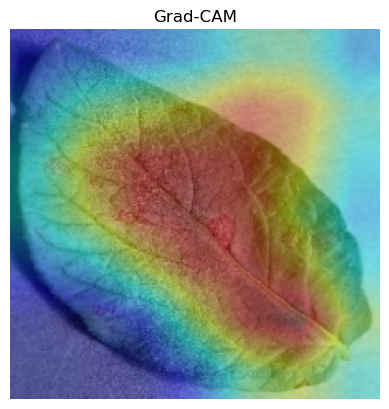

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms, datasets
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import sys
from torch.utils.data import DataLoader

# الجهاز
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# تحميل النموذج
sys.path.append("../models")
from mobilenet_v2_psa import MobileNetV2_PSA

model = MobileNetV2_PSA(num_classes=2).to(device)
model.load_state_dict(torch.load("mobilenet_v2_psa.pth", map_location=device))
model.eval()

# 📌 طباعة أسماء العقد (مرّة واحدة فقط لتحديد الطبقة المناسبة)
train_nodes, eval_nodes = get_graph_node_names(model)
print("⚠️ Available output nodes (for Grad-CAM):")
for node in eval_nodes:
    print(node)
# ❗ عدلي هنا بعد معرفة الاسم الصحيح للطبقة الأخيرة التي تريدين استخراج ميزاتها
return_nodes = {'features.18': 'feat'}
  # مبدئياً، جرّبي هذا أو اختاري واحد من القائمة المطبوعة

# إنشاء extractor
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)
feature_extractor.eval()

# إعداد البيانات
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_val_dataset = datasets.ImageFolder('../../dataset_split/val', transform=transform)

# تحديد الكلاسات المطلوبة
selected_classes = ['Tomato___Late_blight', 'Potato___Early_blight']
selected_class_indices = [full_val_dataset.class_to_idx[cls] for cls in selected_classes]
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(selected_class_indices)}

# تصفية val_dataset على الكلاسات المحددة فقط
filtered_val_samples = [
    (img_path, index_mapping[label])
    for img_path, label in full_val_dataset.samples
    if label in selected_class_indices
]

val_dataset = datasets.ImageFolder('../../dataset_split/val', transform=transform)
val_dataset.samples = filtered_val_samples
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# دالة Grad-CAM
def generate_grad_cam(image_tensor, model, feature_extractor):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    model.zero_grad()

    # لحفظ التفعيلات والتدرجات
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # ربط الـ hooks بالطبقة المطلوبة
    target_layer = model.features[18]
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # التمرير الأمامي والخلفي
    output = model(image_tensor)
    class_idx = torch.argmax(output)
    score = output[0, class_idx]
    score.backward()

    # إزالة الـ hooks
    forward_handle.remove()
    backward_handle.remove()

    # استخراج التفعيلات والتدرجات
    activ = activations[0].detach()
    grad = gradients[0].detach()

    pooled_gradients = torch.mean(grad, dim=[0, 2, 3])
    for i in range(activ.shape[1]):
        activ[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activ, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image = (image * np.array([0.229, 0.224, 0.225]) + 
             np.array([0.485, 0.456, 0.406]))
    image = np.clip(image, 0, 1)
    image = np.uint8(image * 255)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(image, 0.6, heatmap_color, 0.4, 0)

    return superimposed_img


# تجربة Grad-CAM على أول صورة
sample_img, label = val_dataset[0]
grad_cam_img = generate_grad_cam(sample_img, model, feature_extractor)

if grad_cam_img is not None:
    plt.imshow(cv2.cvtColor(grad_cam_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.savefig("gradcam_psa.png")
    plt.show()


/tmp/ipykernel_71126/77113504.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mobilenet_v2_psa.pth", map_location=device))


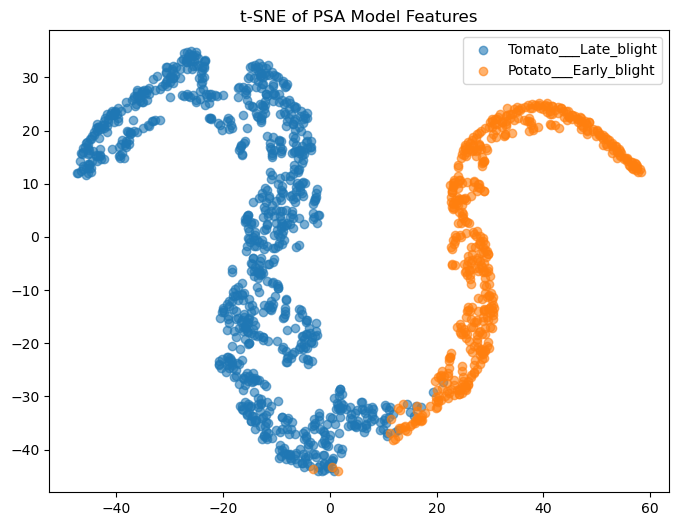

In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms, datasets
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import sys
from torch.utils.data import DataLoader

# الجهاز
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# تحميل النموذج
sys.path.append("../models")
from mobilenet_v2_psa import MobileNetV2_PSA

model = MobileNetV2_PSA(num_classes=2).to(device)
model.load_state_dict(torch.load("mobilenet_v2_psa.pth", map_location=device))
model.eval()


# إعداد البيانات
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_val_dataset = datasets.ImageFolder('../../dataset_split/val', transform=transform)

# تحديد الكلاسات المطلوبة
selected_classes = ['Tomato___Late_blight', 'Potato___Early_blight']
selected_class_indices = [full_val_dataset.class_to_idx[cls] for cls in selected_classes]
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(selected_class_indices)}

# تصفية val_dataset على الكلاسات المحددة فقط
filtered_val_samples = [
    (img_path, index_mapping[label])
    for img_path, label in full_val_dataset.samples
    if label in selected_class_indices
]

val_dataset = datasets.ImageFolder('../../dataset_split/val', transform=transform)
val_dataset.samples = filtered_val_samples
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


features, labels_list = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        
        # Forward pass to extract features before classification
        x = model.features(images)  # shape: [B, C, H, W]
        x = torch.mean(x, dim=[2, 3])  # Global Average Pooling: shape [B, C]
        
        features.append(x.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

# Convert features to numpy array
features_np = np.concatenate(features, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(features_np)

# Plot t-SNE
plt.figure(figsize=(8, 6))
for idx, cls in enumerate(selected_classes):
    indices = np.where(np.array(labels_list) == idx)
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=cls, alpha=0.6)

plt.legend()
plt.title("t-SNE of PSA Model Features")
plt.savefig("tsne_psa.png")
plt.show()
